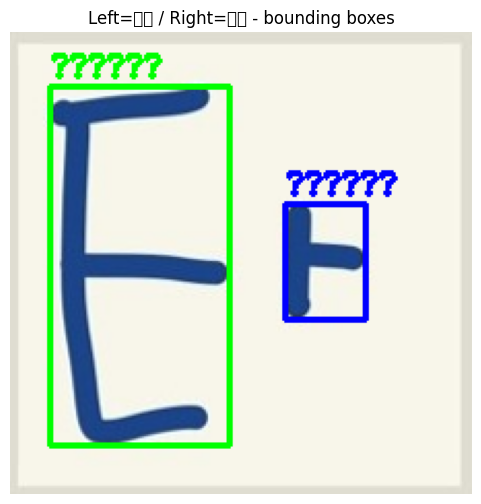

초성 bboxes: [(19, 26, 87, 174)]
중성 bboxes: [(133, 83, 39, 56)]


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ---------------------------
# 1) 이미지 로딩 + 전처리
# ---------------------------
img_path = "unclear_Ta.png"  # 예: "타" 이미지
img = Image.open(img_path).convert("RGB")
img = img.resize((224, 224))  # 원하는 크기로 리사이즈
img_np = np.array(img)

# 그레이스케일 변환
gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

# Otsu 이진화 (글자 부분을 흰색(255), 배경을 검정(0)으로 만들기 위해 BINARY_INV 사용)
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# 모폴로지 연산(Closing)으로 작은 구멍 메우기 (필요에 따라 파라미터 조절)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=1)

# ---------------------------
# 2) 컨투어 찾기
# ---------------------------
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 원본 이미지를 OpenCV BGR 포맷으로 변환 (시각화용)
img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

# ---------------------------
# 3) 컨투어별로 바운딩 박스를 구하고,
#    x중심이 이미지 폭의 절반(=112)보다 작으면 '초성',
#    크면 '중성'으로 간주
# ---------------------------
width = 224  # 리사이즈된 이미지 폭
mid_x = width // 2  # 112

bboxes_choseong = []
bboxes_jungseong = []

for c in contours:
    area = cv2.contourArea(c)
    if area < 10:  # 너무 작은 잡음은 무시
        continue
    x, y, w, h = cv2.boundingRect(c)
    cx = x + w // 2  # 바운딩 박스의 중심 x좌표

    if cx < mid_x:
        # 왼쪽 절반 => 초성
        bboxes_choseong.append((x, y, w, h))
        color = (0, 255, 0)  # 초성은 초록색
        cv2.rectangle(img_cv, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img_cv, "초성", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    else:
        # 오른쪽 절반 => 중성
        bboxes_jungseong.append((x, y, w, h))
        color = (255, 0, 0)  # 중성은 파란색
        cv2.rectangle(img_cv, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img_cv, "중성", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# ---------------------------
# 4) 결과 시각화
# ---------------------------
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
plt.title("Left=초성 / Right=중성 - bounding boxes")
plt.axis('off')
plt.show()

print("초성 bboxes:", bboxes_choseong)
print("중성 bboxes:", bboxes_jungseong)


In [5]:
def evaluate_bi_bboxes(bboxes, total_img_size=(224,224)):
    """
    bboxes: {'초성':(x, y, w, h), '중성':(x, y, w, h)} 형태.
    total_img_size: 전체 이미지 크기 (width, height)
    
    조건 (예시):
      1. 초성의 y 좌표는 중성의 y 좌표보다 작아야 함.
         (즉, 초성의 top < 중성의 top)
      2. 초성의 바닥(= y + h)은 중성의 바닥보다 작아야 함.
      3. 초성의 높이(h1)는 중성의 높이(h2)의 0.5 ~ 0.8배여야 함.
      4. 초성의 너비(w1)는 중성의 너비(w2)보다 커야 함.
      5. 초성의 x좌표와 y좌표는 각각 20~70 범위에 있어야 함.
      6. 중성의 x좌표와 y좌표는 각각 110~160, 0~50 범위에 있어야 함.
      7. 초성의 높이는 전체 이미지 높이의 30% ~ 50%여야 함.
      8. 중성의 높이는 전체 이미지 높이의 50% ~ 80%여야 함.
      9. 초성의 너비는 전체 이미지 너비의 15% ~ 40%여야 함.
      10. 중성의 너비는 전체 이미지 너비의 0% ~ 35%여야 함.
      
    반환:
      (bool, messages)
      - 모든 조건이 만족하면 (True, [])
      - 하나라도 불만족이면 (False, [문제 메시지들])
    """
    messages = []
    total_w, total_h = total_img_size

    # 필수 바운딩 박스 존재 확인
    if '초성' not in bboxes or '중성' not in bboxes:
        messages.append("초성과 중성 바운딩 박스가 모두 필요합니다.")
        return False, messages

    x1, y1, w1, h1 = bboxes['초성']
    x2, y2, w2, h2 = bboxes['중성']

    # 조건 1: 초성의 y 좌표는 중성의 y 좌표보다 커야함.
    if not (y1 > y2):
        messages.append(f"초성의 y 좌표 ({y1})가 중성의 y 좌표 ({y2})보다 작거나 같습니다.")
        
    # 조건 2: 초성의 바닥(= y1+h1)은 중성의 바닥(= y2+h2)보다 작아야 함.
    if not ((y1 + h1) < (y2 + h2)):
        messages.append(f"초성의 바닥 ({y1+h1})가 중성의 바닥 ({y2+h2})보다 크거나 같습니다.")
    
    # 조건 3: 초성의 높이는 중성의 높이의 0.5~0.8배여야 함.
    if h2 == 0:
        messages.append("중성의 높이가 0입니다.")
    else:
        ratio_h = h1 / h2
        if not (0.4 <= ratio_h <= 0.8):
            messages.append(f"초성의 높이 비율 ({ratio_h:.2f})가 0.4~0.8 범위를 벗어났습니다.")
    
    # 조건 4: 초성의 너비는 중성의 너비보다 커야 함.
    if not (w1 > w2):
        messages.append(f"초성의 너비 ({w1})가 중성의 너비 ({w2})보다 작거나 같습니다.")
    
    # 조건 5: 초성의 x, y 좌표는 각각 20~70
    if not (20 <= x1 <= 70):
        messages.append(f"초성의 x 좌표 ({x1})가 20~70 범위를 벗어났습니다.")
    if not (20 <= y1 <= 70):
        messages.append(f"초성의 y 좌표 ({y1})가 20~70 범위를 벗어났습니다.")
    
    # 조건 6: 중성의 x, y 좌표는 각각 110~160
    if not (110 <= x2 <= 160):
        messages.append(f"중성의 x 좌표 ({x2})가 110~160 범위를 벗어났습니다.")
    if not (0 <= y2 <= 50):
        messages.append(f"중성의 y 좌표 ({y2})가 0~50 범위를 벗어났습니다.")
    
    # 조건 7: 초성의 높이는 전체 이미지 높이의 30% ~ 50%
    if not (0.3 * total_h <= h1 <= 0.5 * total_h):
        messages.append(f"초성의 높이 ({h1})가 전체 높이 ({total_h})의 30%~50% 범위를 벗어났습니다.")
    
    # 조건 8: 중성의 높이는 전체 이미지 높이의 50% ~ 80%
    if not (0.5 * total_h <= h2 <= 0.8 * total_h):
        messages.append(f"중성의 높이 ({h2})가 전체 높이 ({total_h})의 50%~80% 범위를 벗어났습니다.")
    
    # 조건 9: 초성의 너비는 전체 이미지 너비의 15% ~ 40%
    if not (0.15 * total_w <= w1 <= 0.40 * total_w):
        messages.append(f"초성의 너비 ({w1})가 전체 너비 ({total_w})의 15%~40% 범위를 벗어났습니다.")
    
    # 조건 10: 중성의 너비는 전체 이미지 너비의 0% ~ 35%
    if not (0 <= w2 <= 0.35 * total_w):
        messages.append(f"중성의 너비 ({w2})가 전체 너비 ({total_w})의 0%~35% 범위를 벗어났습니다.")
    
    if messages:
        return False, messages
    else:
        return True, []


In [6]:
is_ok, errors = evaluate_bi_bboxes(bboxes, total_img_size=(224,224))

if is_ok:
    print("글씨가 기준 범위 내에 있습니다!")
else:
    print("글씨가 기준을 벗어났습니다. 문제 항목:")
    for e in errors:
        print(" -", e)

글씨가 기준을 벗어났습니다. 문제 항목:
 - 초성의 높이 비율 (0.08)가 0.4~0.8 범위를 벗어났습니다.
 - 초성의 너비 (19)가 중성의 너비 (77)보다 작거나 같습니다.
 - 초성의 x 좌표 (87)가 20~70 범위를 벗어났습니다.
 - 초성의 y 좌표 (112)가 20~70 범위를 벗어났습니다.
 - 중성의 x 좌표 (19)가 110~160 범위를 벗어났습니다.
 - 초성의 높이 (11)가 전체 높이 (224)의 30%~50% 범위를 벗어났습니다.
 - 초성의 너비 (19)가 전체 너비 (224)의 15%~40% 범위를 벗어났습니다.
